In [34]:
import yfinance as yf
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

##N-BEATS


In [52]:
input_size = 10
backcast_length = 10
forecast_length = 5
hidden_units = 128
num_blocks = 4
num_layers = 4
num_stacks = 4

In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Block(nn.Module):
    def __init__(self,
                  input_size: int,
                  backcast_length: int,
                  forecast_length: int,
                  hidden_units: int,
                  hidden_layers: int):
        super(Block, self).__init__()
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length
    
        layers = []
        for _ in range(hidden_layers):
            layers.append(nn.Linear(input_size, hidden_units))
            layers.append(nn.ReLU())
            input_size = hidden_units
        layers.append(nn.Linear( hidden_units, backcast_length + forecast_length))
        self.model = nn.Sequential(*layers)
    
    def forward(self,x):
        y = self.model(x)
        y_1d = y.squeeze()
        backcast, forecast =torch.split(y_1d, [self.backcast_length, self.forecast_length], dim=0)
    
        return backcast, forecast
    
class NbeatsStack(nn.Module):
    def __init__(self, 
                 input_size: int,
                 backcast_length: int,
                 forecast_length: int,
                 hidden_units: int,
                 hidden_layers: int,
                 num_blocks: int,
                 ):
        super(NbeatsStack, self).__init__()
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length

        self.blocks = nn.ModuleList([Block(input_size, backcast_length, forecast_length, hidden_units, hidden_layers) for _ in range(num_blocks)])
    
    def forward(self, x):
        
        forecasts = torch.tensor([0 for _ in range(self.forecast_length)])
        for block in self.blocks:
            backcast, forecast = block(x)    
            x = x - backcast.squeeze()
            forecasts =  forecasts + forecast.squeeze()
        fc = forecasts
        return x, fc
        
class Nbeat(nn.Module):
    def __init__(self, 
                 input_size: int,
                 backcast_length: int,
                 forecast_length: int,
                 hidden_units: int,
                 hidden_layers: int,
                 num_blocks: int,
                 num_stacks: int
                 ):
        super(Nbeat, self).__init__()
        self.forecast_length = forecast_length    

        self.stacks = nn.ModuleList([NbeatsStack(input_size, backcast_length, forecast_length, hidden_units, hidden_layers, num_blocks) for _ in range(num_stacks)])

    def forward(self, x):
        backcasts = []
        fcs = torch.tensor([0 for _ in range(self.forecast_length)])
        for stack in self.stacks:
            backcast, forecast = stack(x)
            fcs = fcs + forecast
            x = backcast.squeeze()

       
        return backcast, fcs


##Get Data

In [37]:
GetFacebookInformation = yf.Ticker("META")
facebook_history = GetFacebookInformation.history(period="max")
print(facebook_history)


                                 Open        High         Low       Close  \
Date                                                                        
2012-05-18 00:00:00-04:00   42.005431   44.952305   37.959724   38.189480   
2012-05-21 00:00:00-04:00   36.491281   36.621144   32.965024   33.993931   
2012-05-22 00:00:00-04:00   32.575438   33.554399   30.907208   30.967144   
2012-05-23 00:00:00-04:00   31.336752   32.465554   31.326762   31.966084   
2012-05-24 00:00:00-04:00   32.915078   33.174801   31.736328   32.994991   
...                               ...         ...         ...         ...   
2024-02-15 00:00:00-05:00  474.776242  488.102099  471.719488  483.516968   
2024-02-16 00:00:00-05:00  477.603230  478.452335  468.712669  472.818329   
2024-02-20 00:00:00-05:00  469.222153  475.675297  466.065498  471.250000   
2024-02-21 00:00:00-05:00  466.500000  469.000000  461.790009  468.029999   
2024-02-22 00:00:00-05:00  480.239990  489.989990  476.061798  488.549988   

In [73]:
train_data_set = facebook_history[2400:2800]
test_data_set = facebook_history[2800:]

In [6]:
#x_train = []
#y_train = []
#for i in range(backcast_length, len(train_data_set) - forecast_length):
#    x_res = []
#    for b in range(backcast_length):
#        x_res.append(train_data_set.iloc[i - backcast_length + b, 1].tolist())
#    x_train.append(x_res)
#
#    y_res = []
#    for f in range(forecast_length):
#        y_res.append(train_data_set.iloc[i + f, 1].tolist())
#    y_train.append(y_res)

In [40]:
#Pre-process data
def pre_process(dataset, backcast, forecast):
    x_l = []
    y_l = []

    for i in range(backcast, len(dataset) - forecast):
        x = []
        for b in range(backcast):
            x.append(dataset.iloc[i - backcast + b, 1].tolist())
        
        #Normalize with max value
        mx = max(x) 
        x = [elem/ mx for elem in x]
        x_l.append(x)


        y = []
        for f in range(forecast_length):
            y.append(dataset.iloc[i + f, 1].tolist())

        #Normalize with max value
        y = [elem/mx for elem in y] 
        y_l.append(y)

    return x_l,y_l

x_train, y_train = pre_process(train_data_set, backcast_length, forecast_length)
x_test, y_test = pre_process(test_data_set, backcast_length, forecast_length)

test_data_loader = DataLoader(TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train)),shuffle=True)

In [41]:
print(x_train)
print(y_train)
print(x_test)
print(y_test)

[[1.0, 0.8146666680616844, 0.7464444647052579, 0.7222222246436403, 0.7379999973785567, 0.7322222411073788, 0.7042222377373384, 0.656666644393905, 0.659333352134132, 0.6477777561733384], [1.0, 0.9162575246649702, 0.8865248241492502, 0.9058919755910245, 0.8987998034208721, 0.8644299139093004, 0.8060556177611822, 0.8093289905954628, 0.7951445438593671, 0.7542280319477287], [1.0, 0.9675498430131945, 0.9886870789107725, 0.9809467090046747, 0.9434355414711375, 0.8797260552440391, 0.8832986019857182, 0.8678177504191431, 0.8231616239370174, 0.8264364043721686], [0.9786209040772894, 1.0, 0.9921710619353645, 0.9542306778303523, 0.8897922042363751, 0.8934056293714692, 0.8777476402090841, 0.8325805419080495, 0.8358927935850502, 0.818127077032571], [1.0, 0.9921710619353645, 0.9542306778303523, 0.8897922042363751, 0.8934056293714692, 0.8777476402090841, 0.8325805419080495, 0.8358927935850502, 0.818127077032571, 0.8235471497706919], [1.0, 0.9617602391758894, 0.8968133000177554, 0.9004552376570629, 0.

##Define model


In [72]:
model = Nbeat(input_size,
                    backcast_length,
                    forecast_length,
                    hidden_units,
                    num_layers,
                    num_blocks,
                    num_stacks)

print(model)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

Nbeat(
  (stacks): ModuleList(
    (0-3): 4 x NbeatsStack(
      (blocks): ModuleList(
        (0-3): 4 x Block(
          (model): Sequential(
            (0): Linear(in_features=10, out_features=128, bias=True)
            (1): ReLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): ReLU()
            (4): Linear(in_features=128, out_features=128, bias=True)
            (5): ReLU()
            (6): Linear(in_features=128, out_features=128, bias=True)
            (7): ReLU()
            (8): Linear(in_features=128, out_features=15, bias=True)
          )
        )
      )
    )
  )
)


In [76]:
##Train
num_epochs = 1
train_loss = []
train_outputs = []
for epoch in range(num_epochs):
    model.train()
    ac_loss = 0
    for inputs, labels in test_data_loader:
        x = inputs
        y = labels
        optimizer.zero_grad()
        backcasts, forecasts = model(x)
       
        train_outputs.append(forecasts.squeeze().tolist()[0])
        loss = criterion(forecasts.squeeze(), y)
       
        ac_loss += loss
   
        
        loss.backward()
        optimizer.step()
        train_loss.append(loss)
    
    print(epoch)

        

c:\Users\Hampus\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0


In [203]:
print(train_outputs)




[0.9914044141769409, 0.9554593563079834, 0.9938516616821289, 0.9770538210868835, 0.963323712348938, 0.9608933925628662, 0.9749191999435425, 0.9719977378845215, 0.9745090007781982, 1.013707160949707, 1.0386104583740234, 1.0630443096160889, 1.0732356309890747, 1.0449559688568115, 1.0628929138183594, 1.0471502542495728, 1.015284776687622, 1.0050760507583618, 0.9643216729164124, 0.8446681499481201, 0.9224703311920166, 0.8817586898803711, 0.8649184703826904, 0.856300950050354, 0.8571403622627258, 0.8711192607879639, 0.8881890177726746, 0.859894871711731, 0.8957903385162354, 0.9347820281982422, 0.935890793800354, 0.9742902517318726, 0.9935253858566284, 1.014169454574585, 1.0224850177764893, 1.0162708759307861, 1.02443265914917, 1.0288352966308594, 1.0274931192398071, 1.017127513885498, 1.0025676488876343, 0.9820385575294495, 0.953852117061615, 0.8751278519630432, 0.9392834901809692, 0.9207619428634644, 0.894216775894165, 0.8319077491760254, 0.8913671970367432, 0.8889197707176208, 0.893595635

[0.6144444377455778, 0.7572285741630616, 0.8088716699691413, 0.8235471497706919, 0.8358928237784635, 0.8518967921728385, 0.876301660592601, 0.9470845596302894, 0.954499485897181, 1.0325901144021608, 1.0657807752289667, 1.003117149723408, 0.9922311838119651, 1.0099440612373618, 1.029230755717709, 0.9871449751554833, 0.9997009700683062, 0.9835575906017333, 0.9623318260590651, 0.956352758908755, 0.9485799345907505, 0.939910363038575, 0.9455904435394857, 0.953662176267584, 0.9829597079614127, 0.9712919625428607, 0.9437799467712995, 0.9544072339601253, 0.9449512556257471, 0.9276155267697859, 0.8695255152800282, 0.8908150631416141, 0.8972018888266826, 0.8962894375004394, 0.8819950816963358, 0.9067118510859882, 0.9344106677766785, 0.8990446106860355, 0.7898294907023898, 0.7881967529258306, 0.7922034198052991, 0.7315254077325075, 0.7064406845654011, 0.7514412040244036, 0.7511020460931807, 0.7612750357310092, 0.7171922569324364, 0.7499114450398694, 0.8891604480291821, 0.9338602040109877, 0.9242

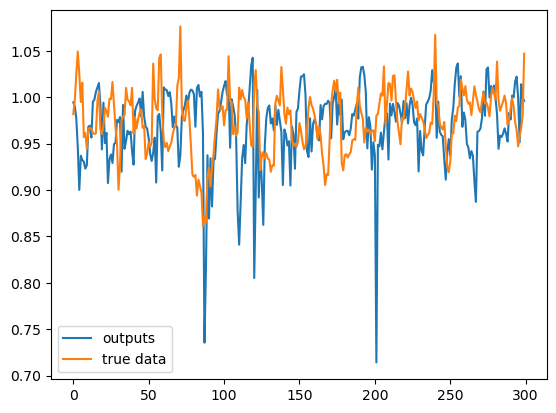

In [82]:
### PLOT TRAIN DATA

import matplotlib.pyplot as plt
backcast, forecast = model(torch.Tensor(x_train[1]))

bc = backcast.squeeze().tolist()
fc = forecast.squeeze().tolist()
pred = bc + fc

actual = x_train[1] + y_train[1]

yyy = [x[0] for x in y_train]
print(yyy)
print(train_outputs)
print(len(train_outputs))

plt.plot( train_outputs[2000:2100], label="outputs")

plt.plot(yyy[2000:2100], label="true data")
plt.legend()


In [78]:
##Eval
outputs = []

eval_loss = []
model.eval()

with torch.no_grad():


    for i in range(len(x_test)):
        loss = 0
        x = torch.Tensor(x_test[i])
        y = torch.Tensor(y_test[i])
        optimizer.zero_grad()
        backcasts, forecasts = model(x)
        outputs.append(forecasts.squeeze().tolist()[0])
        loss = criterion(forecasts.squeeze(), y)
        eval_loss.append(loss.item())

yyy_test = [x[0] for x in y_test]
print(len(yyy_test))



144


[1.014601469039917, 1.0066205263137817, 0.9938734769821167, 0.9863082766532898, 0.9876438975334167, 1.0017770528793335, 1.0116151571273804, 1.0145838260650635, 1.0140085220336914, 1.0103120803833008, 1.0071406364440918, 1.00729238986969, 1.0067834854125977, 1.0064194202423096, 1.0020861625671387, 0.998780369758606, 0.9908274412155151, 0.9902957677841187, 1.000469446182251, 0.9946712255477905, 0.9850813150405884, 0.9668484926223755, 0.9626705050468445, 0.9772677421569824, 0.9881712198257446, 1.002907156944275, 0.9938663244247437, 0.9920209646224976, 1.0087406635284424, 1.0144100189208984, 1.0154306888580322, 1.0158474445343018, 1.0160356760025024, 1.015395998954773, 1.0143945217132568, 1.0153393745422363, 1.0150996446609497, 1.0159364938735962, 1.0152384042739868, 1.0139296054840088, 1.0153976678848267, 1.0097934007644653, 1.0079028606414795, 1.009092926979065, 1.0042147636413574, 1.0048315525054932, 1.0022847652435303, 0.9997701048851013, 0.9997745156288147, 1.0054397583007812, 1.01309

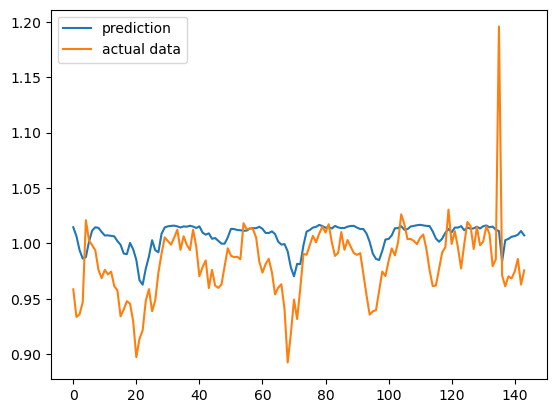

In [79]:

plt.plot( outputs, label = "prediction")
plt.plot(yyy_test, label="actual data")
plt.legend()
print(outputs)

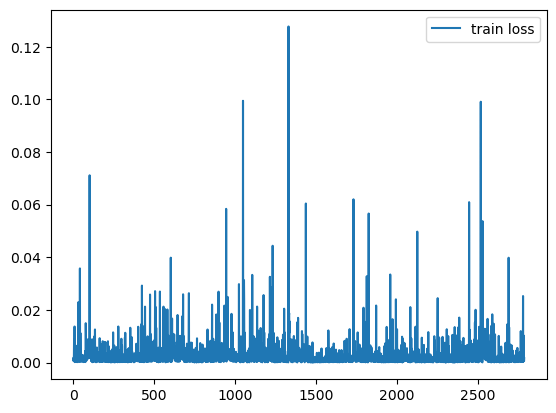

In [80]:
##Plot loss
import matplotlib.pyplot as plt


#plt.plot(eval_loss, label = "eval loss")
plt.plot([x.item() for x in train_loss], label="train loss")

plt.legend()
